In [1]:
pref = 'knn_pretrain_angles_radius_best_'
def prefix(dic,pref):
    for key in dic:
        dic[key] = [pref+scen for scen in dic[key]]
    return dic

In [2]:
from utils import flatten_list_of_list as flat
import copy
scen_folder = 'knn_pretrain_angles_radius_best' #Folder in which all experiments are stored. 
dict_file_names = {}
dict_file_names['clump'] = flat([['base'],["clump%d"%i for i in range(2,8)]]) #base as has ceiling accuracy
dict_file_names['embdim'] = ['base',"embdim3","embdim4","embdim5","embdim7","embdim10"]
dict_file_names['noise'] = ['base','noise5e-3','noise1e-2','noise2e-2']
dict_file_names['ncon'] = ['ncon50','base','ncon300']
dict_file_names = prefix(dict_file_names,pref)
print(dict_file_names['clump'])
#Exp names if need to change
dict_exp_names = copy.deepcopy(dict_file_names)
#Names to replace with
dict_new_names = copy.deepcopy(dict_exp_names)
dict_new_names['clump'] = flat([['clump1 \n (base)'],["clump%d"%i for i in range(2,8)]])
dict_new_names['clump'] = flat([['clump1 \n (base)'],['clump2-2','clump2-4','clump2-8','clump3-2','clump3-4','clump3-8']])
dict_new_names['embdim'] = ['emdim2 \n (base)',"embdim3","embdim4","embdim5","embdim7","embdim10"]
dict_new_names['noise'] = ['noise1e-3 \n (base)','noise5e-3','noise1e-2','noise2e-2']
dict_new_names['ncon'] = ['ncon50','ncon200 \n (base)','ncon300']

['knn_pretrain_angles_radius_best_base', 'knn_pretrain_angles_radius_best_clump2', 'knn_pretrain_angles_radius_best_clump3', 'knn_pretrain_angles_radius_best_clump4', 'knn_pretrain_angles_radius_best_clump5', 'knn_pretrain_angles_radius_best_clump6', 'knn_pretrain_angles_radius_best_clump7']


In [3]:
#Paths
import os
from pathlib import Path
fp_repo = "/Users/roseline/Docs/UCL/Projects/B.Roads/B.Roads code/Fork/unsupervised-alignment-team-master"
#fp_repo = '/content/gdrive/My Drive/unsupervised-alignment-team-master'
fp_intersect = fp_repo / Path('python','assets','intersect')
fp_save = fp_repo / Path('save',scen_folder)
os.chdir(fp_repo / Path('python'))

In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import time
from matplotlib import gridspec
import matplotlib
from matplotlib.ticker import MaxNLocator
#Custom
import utils
import models
#KERAS
import tensorflow as tf
import keras
from tensorflow.keras.models import load_model
sns.set(font_scale=1)

Using TensorFlow backend.


In [5]:
def get_exps_dfs(fp_save,exp_names,file_names):
    #== Get path of save folder/ models and data
    n_exp = len(file_names)
    fp_runs_list = []
    fp_models_list = []
    for i in range(n_exp):
        save_folder = file_names[i]
        fp_runs_list.append(fp_save / Path(save_folder))
        fp_models_list.append(fp_save / Path(save_folder,'models'))
    #====Get params====
    dict_params_list = []
    for i in range(n_exp):
        fp_runs = fp_runs_list[i]
        with open(fp_runs /Path('dict_params.pickle'), 'rb') as handle:
            dict_params = pickle.load(handle)
            dict_params_list.append(dict_params)
    #display(pd.DataFrame(dict_params_list))
    df_params = pd.DataFrame(dict_params_list)
    ##========GET RESULTS==========
    df_all_res_list = []
    df_summary_res_list = []
    for i in range(n_exp):
        fp_runs = fp_runs_list[i]
        with open(str(fp_runs)+'/all_res.pickle', 'rb') as handle:
            all_res = pickle.load(handle)
        with open(str(fp_runs)+'/summary_res.pickle', 'rb') as handle:
            summary_res = pickle.load(handle)
            df_all_res = pd.DataFrame(utils.flatten_list_of_list(all_res))
            df_summary_res = pd.DataFrame(summary_res)
        df_all_res_list.append(df_all_res)
        df_summary_res_list.append(df_summary_res)
    df_all_res = pd.concat(df_all_res_list)
    df_summary_res = pd.concat(df_summary_res_list)
    #==Add columns for average accuracies to df_all_res
    df_all_res = add_avg_acc_columns(df_all_res)
    return df_all_res,df_summary_res, df_params
def add_avg_acc_columns(df_all_res):
    #==Add columns for average accuracies to df_all_res
    for s in ['1','5','10','half']:
        df_all_res['acc%s'%s] = 1/2 *(df_all_res['acc_f%s'%s]+df_all_res['acc_g%s'%s])
    return df_all_res
def get_dfs_from_key(key):
    file_names,exp_names,new_names = dict_file_names[key],dict_exp_names[key],dict_new_names[key]
    new_names = [n.replace(" \n (base)", "") for n in new_names]
    print(new_names)
    df_all_res,df_summary_res, df_params = get_exps_dfs(fp_save,exp_names,file_names)
    for df in [df_all_res,df_summary_res, df_params]:
            df["experiment_name"] = df["experiment_name"].replace(exp_names,new_names)
    return df_all_res,df_summary_res, df_params

In [7]:
from matplotlib import cm
#For a specific experiment (key)
def get_matches_data(scen,df_summary_res):
    scen_matches_acc = list(df_summary_res[df_summary_res['experiment_name']==scen]['matches_acc'])
    scen_matches_acc = np.array(scen_matches_acc)
    avg_matches_acc= np.mean(scen_matches_acc)
    return avg_matches_acc,scen_matches_acc
def get_rad_data(scen,df_params):
    df = df_params[df_params['experiment_name']== scen]
    k_test,all_accs_per_k = list(df['params_tested'])[0],np.array(list(df['all_accs'])[0])
    k, best_avg = list(df['rad'])[0], list(df['avg'])[0]
    avg_accs_per_k = np.mean(all_accs_per_k,axis = 1)
    return k, best_avg , k_test,all_accs_per_k,avg_accs_per_k
# def plot_rad_data(scen_list,df_params,df_summary_res):
#     fig,ax = plt.subplots()
#     colors = [cm.Dark2(x) for x in np.linspace(0, 1, len(scen_list))]
#     for i,scen in enumerate(scen_list):
#         #==Get k data from param and run data. 
#         rad, best_avg , rad_test,all_accs_per_rad,avg_accs_per_rad = get_rad_data(scen,df_params)
#         avg_matches_acc,scen_matches_acc = get_matches_data(scen,df_summary_res)
#         x = rad_test #np.arange(0,len(k_test))
#         x_rad = rad #np.where(k_test==k)
#         ax.scatter(x_rad,avg_matches_acc,marker = 'x',color = colors[i])
#         ax.scatter(x_rad,best_avg,marker = '*',color = colors[i])
#         sns.lineplot(x=x, y=avg_accs_per_rad,ax = ax,label = scen,color = colors[i])
#     plt.xlabel('rad')
#     plt.ylabel('Matches accuracy')
#     plt.legend(loc="lower right",bbox_to_anchor=(1.25, 0))
#     plt.show()
    
def plot_rad_data(scen_list,df_params,df_summary_res):
    fig,ax = plt.subplots()
    colors = [cm.Dark2(x) for x in np.linspace(0, 1, len(scen_list))]
    for i,scen in enumerate(scen_list):
        #==Get k data from param and run data. 
        rad, best_avg , rad_test,all_accs_per_rad,avg_accs_per_rad = get_rad_data(scen,df_params)
        avg_matches_acc,scen_matches_acc = get_matches_data(scen,df_summary_res)
        x = rad_test #np.arange(0,len(k_test))
        x_rad = rad #np.where(k_test==k)
        ax.scatter(x_rad,avg_matches_acc,marker = 'x',color = colors[i])
        ax.scatter(x_rad,best_avg,marker = '*',color = colors[i])
        ax.set_ylim(0,1)
        ax.axvline(x=x_rad, ymin=0, ymax = best_avg,color = colors[i])
        sns.lineplot(x=x, y=avg_accs_per_rad,ax = ax ,color = colors[i],label = scen)
#         ax.plot(x,avg_accs_per_rad,label = scen,color = colors[i])
    ax.set_xlabel('Radius',fontsize = 15)
    ax.set_ylabel('Matches accuracy',fontsize = 15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.legend(loc="lower right",bbox_to_anchor=(1.35, 0),fontsize = 15)
    plt.show()

['clump1', 'clump2-2', 'clump2-4', 'clump2-8', 'clump3-2', 'clump3-4', 'clump3-8']


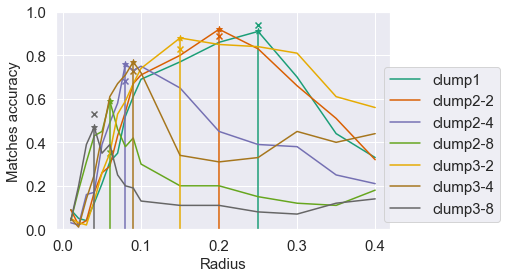

['emdim2', 'embdim3', 'embdim4', 'embdim5', 'embdim7', 'embdim10']


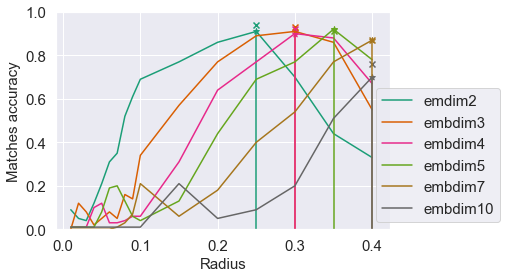

['noise1e-3', 'noise5e-3', 'noise1e-2', 'noise2e-2']


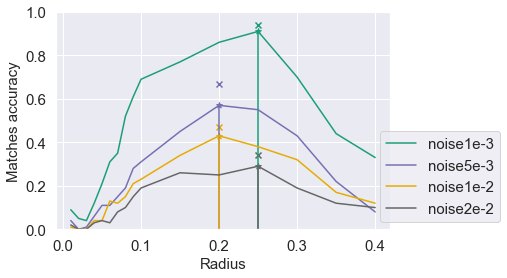

['ncon50', 'ncon200', 'ncon300']


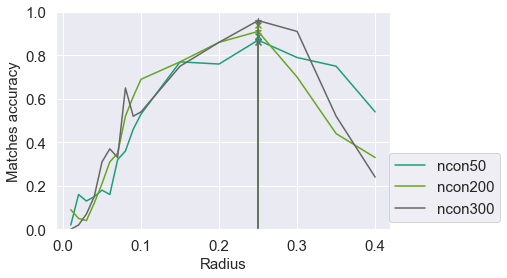

In [8]:
for key in list(dict_file_names):
    df_all_res,df_summary_res, df_params = get_dfs_from_key(key)
    scen_list = list(df_params['experiment_name'])
    plot_rad_data(scen_list,df_params,df_summary_res)

In [40]:
key = 'clump'
df_all_res,df_summary_res, df_params = get_dfs_from_key(key)

['clump1', 'clump2', 'clump3', 'clump4', 'clump5', 'clump6', 'clump7']


In [57]:
scen = 'emdim2'
scen_matches_acc = list(df_summary_res[df_summary_res['experiment_name']==scen]['matches_acc'])
scen_matches_acc = np.array(scen_matches_acc)
avg= np.mean(scen_matches_acc)
print(avg,scen_matches_acc)

0.9400000000000001 [0.9 1.  1.  0.9 0.8 1.  0.8 1.  1.  1. ]


In [60]:
print(all_accs_per_rad)

[[0.1 0.  0.1 0.2 0.1 0.1 0.1 0.1 0.1 0. ]
 [0.  0.  0.1 0.1 0.  0.1 0.  0.  0.2 0. ]
 [0.  0.  0.  0.  0.  0.2 0.1 0.  0.1 0. ]
 [0.1 0.2 0.2 0.1 0.  0.1 0.  0.1 0.1 0.3]
 [0.2 0.2 0.1 0.1 0.3 0.  0.4 0.3 0.3 0.2]
 [0.2 0.5 0.3 0.1 0.5 0.  0.3 0.2 0.4 0.6]
 [0.4 0.3 0.5 0.1 0.5 0.  0.5 0.3 0.2 0.7]
 [0.8 0.2 0.8 0.4 0.3 0.6 0.4 0.6 0.7 0.4]
 [0.7 0.8 0.8 0.4 0.4 0.5 0.7 0.7 0.5 0.6]
 [0.2 0.2 0.1 0.1 0.3 0.  0.4 0.3 0.3 0.2]
 [0.8 0.5 0.8 0.6 0.7 0.4 0.7 1.  0.6 0.8]
 [0.7 0.7 0.9 0.8 0.5 0.7 0.8 1.  0.6 1. ]
 [0.8 1.  0.8 1.  1.  0.7 0.5 1.  0.8 1. ]
 [0.9 1.  1.  1.  0.9 0.8 0.9 0.8 1.  0.8]
 [0.5 0.8 0.8 1.  0.7 0.9 0.9 0.4 0.9 0.1]
 [0.4 0.5 0.9 0.7 0.2 0.1 0.6 0.  0.6 0.4]
 [0.  0.7 0.2 1.  0.  0.8 0.  0.1 0.5 0. ]]


['emdim2', 'embdim3', 'embdim4', 'embdim5', 'embdim7', 'embdim10']
[0.09 0.05 0.04 0.12 0.21 0.31 0.35 0.52 0.61 0.21 0.69 0.77 0.86 0.91
 0.7  0.44 0.33]
[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.05 0.1  0.15 0.2  0.25
 0.3  0.35 0.4 ]
0.9400000000000001
0.25 0.9100000000000001
[12]


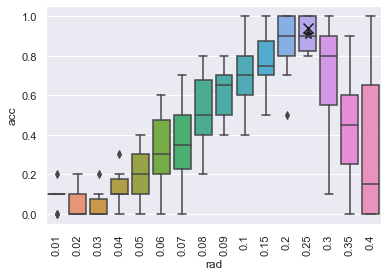

In [61]:
key = 'embdim'
scen = 'emdim2'
df_all_res,df_summary_res, df_params = get_dfs_from_key(key)
rad, best_avg , rad_test,all_accs_per_rad,avg_accs_per_rad = get_rad_data(scen,df_params)
print(avg_accs_per_rad)
print(rad_test)
avg_matches_acc,scen_matches_acc = get_matches_data(scen,df_summary_res)
print(avg_matches_acc)
print(rad,best_avg)
x = np.arange(0,len(rad_test))
x_k = np.where(rad_test==rad)[0]-1
print(x_k)
fig, ax = plt.subplots()
# ax.set_ylim(0,1)
ax.scatter(x_k,avg_matches_acc,marker = 'x',color = 'k',s = 100)
ax.scatter(x_k,best_avg,marker = '*',s = 100,color = 'k')
# ax.plot(x,avg_accs_per_rad,label = scen,color = 'k',linewidth=2)
# sns.lineplot(x,avg_accs_per_rad,label = scen,color = 'k',linewidth=2)
plt.xticks(rotation=90)
df= utils.sns_cat_data_to_df(rad_test,all_accs_per_rad,cat_name='rad',val_name = 'acc')
sns.boxplot(x="rad", y="acc", data=df,ax=ax)

['clump1', 'clump2', 'clump3', 'clump4', 'clump5', 'clump6', 'clump7']
[0.09 0.02 0.04 0.17 0.26 0.29 0.43 0.54 0.67 0.71 0.8  0.92 0.83 0.66
 0.51 0.32]
[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.15 0.2  0.25 0.3
 0.35 0.4 ]
[11]


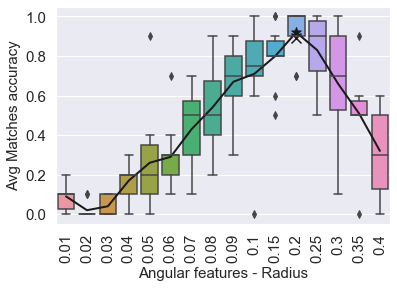

In [80]:
key = 'clump'
scen = 'clump2'
df_all_res,df_summary_res, df_params = get_dfs_from_key(key)
rad, best_avg , rad_test,all_accs_per_rad,avg_accs_per_rad = get_rad_data(scen,df_params)
#Remove extra random value
rad_test = np.delete(rad_test, 9, 0)
avg_accs_per_rad = np.delete(avg_accs_per_rad, 9, 0)
all_accs_per_rad = np.delete(all_accs_per_rad, 9, 0)
print(avg_accs_per_rad)
print(rad_test)
avg_matches_acc,scen_matches_acc = get_matches_data(scen,df_summary_res)
x = np.arange(0,len(rad_test))
x_k = np.where(rad_test==rad)[0]
print(x_k)
fig, ax = plt.subplots()
# ax.set_ylim(0,1)
ax.scatter(x_k,avg_matches_acc,marker = 'x',color = 'k',s = 100)
ax.scatter(x_k,avg_accs_per_rad[x_k],marker = '*',s = 100,color = 'k')
# ax.plot(x,avg_accs_per_rad,label = scen,color = 'k',linewidth=2)
sns.lineplot(x,avg_accs_per_rad,color = 'k',linewidth=2)
plt.xticks(rotation=90)
df= utils.sns_cat_data_to_df(rad_test,all_accs_per_rad,cat_name='Radius',val_name = 'Avg Matches Accuracy')
sns.boxplot(x="Radius", y="Avg Matches Accuracy", data=df,ax=ax)
ax.set_xlabel('Angular features - Radius',fontsize = 15)
ax.set_ylabel('Avg Matches accuracy',fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)